In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torchvision
import os
import cv2 as cv
from torchvision import models
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.nn import Conv2d,Linear,ReLU,MaxPool2d,Flatten,Sequential,Softmax
import torch.nn.functional as F

In [30]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

### custom dataset class

In [31]:
classes=["COVID","Lung_Opacity","Normal","Viral_Pneumonia"]

class XrayImagesDataset(Dataset):
  def __init__(self,data_dir,classes,transform):
    
    self.data_dir=data_dir
    self.transform=transform
    self.classes=classes
    self.data=[]
    
    for c in self.classes:
      for img in os.listdir(self.data_dir+"/"+c+"/images/"):
        self.data.append({"path":img,"class":c})
  
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self,index):
    
    img_class=self.data[index]["class"]
    img_name=self.data[index]["path"]
    path=self.data_dir+"/"+img_class+"/images/"+img_name
    
    image =  Image.open(path).convert('RGB')
        
    return self.transform(image),classes.index(self.data[index]["class"])

In [32]:
#mobilenetv3 takes 224,224 so i'll resize all images i don't feel like augmenting them 😶‍🌫️
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
])
data=XrayImagesDataset("dataset/COVID-19_Radiography_Dataset",classes,transform)

### data splitting into train val and test then loading it in the dataloader

In [33]:
#so i tried this the other way by splitting the custom dataset class
#then loading train valid test seperately but SPLITTING TOOK AGES
#so i used this method i found online it splits data indices instead of
#the data itself then uses the pytorch Subset class for each split and loads 
indices = list(range(data.__len__()))

train_indices, valid_and_test_indices = train_test_split(indices, test_size=0.2, random_state=42)

valid_indices, test_indices = train_test_split(valid_and_test_indices, test_size=0.5, random_state=42)

train_subset = Subset(data, train_indices)
valid_subset = Subset(data, valid_indices)
test_subset = Subset(data, test_indices)

batch_size=10

train_dataloader = DataLoader(train_subset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_subset, batch_size=batch_size)

### some visualisation

In [34]:
#get the first batch of images
images, labels = next(iter(train_dataloader))

In [35]:
#why are the channels there whatever i'll transpose
images[0].shape

torch.Size([3, 224, 224])

In [36]:
#first dim is data length/batch size 
images.shape

torch.Size([10, 3, 224, 224])

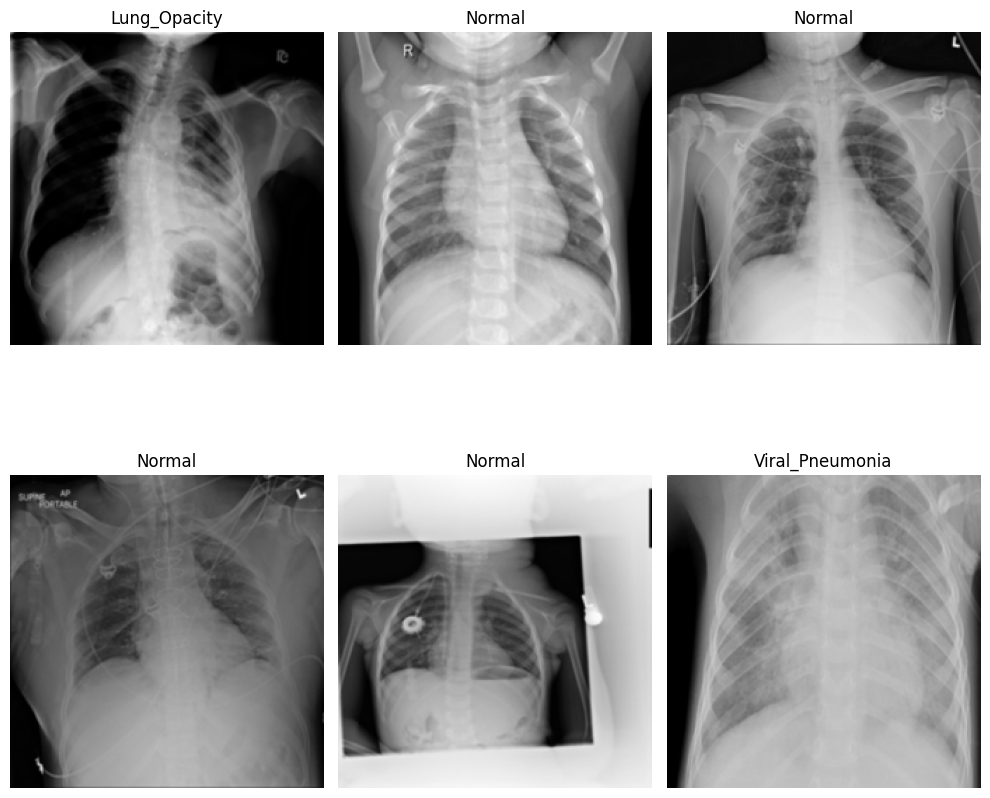

In [37]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    #transpose because pillow wants to act all different and cool
    image = images[i].numpy().transpose((1, 2, 0))
    plt.title(classes[int(labels[i])])
    plt.axis('off')
    plt.imshow(np.asarray(image))
plt.tight_layout()
plt.show()

### contructing the vgg16 architecture look i know i can import it in 1 line but i want to make it aight ?

In [38]:
vgg16_pretrained=torchvision.models.vgg16(pretrained=True)

d:\dev stuff\covid pytorch\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\dev stuff\covid pytorch\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d()
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.conv3 = nn.Conv2d(3, 6, 5)
        self.conv4 = nn.Conv2d(3, 6, 5)
        self.conv5 = nn.Conv2d(3, 6, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc6 = nn.Linear(16 * 5 * 5, 120)
        self.fc7 = nn.Linear(120, 84)
        self.fc8 = nn.Linear(84, 10)

    def forward(self, x):
        
        x=self.conv1()
        x=self.conv1((self.conv2(x)))
        
        
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#vgg16_fn = VGG16()

vgg16_seq=Sequential(# conv1
                     Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     MaxPool2d(kernel_size=2,stride=2),
                     # conv2
                     Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     MaxPool2d(kernel_size=2,stride=2),
                     # conv3
                     Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding="same"),
                     ReLU(),
                     # conv4
                     Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     
                     MaxPool2d(kernel_size=2,stride=2),
                     # conv5
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding="same"),
                     ReLU(),
                     MaxPool2d(kernel_size=2,stride=2),
                     # fully connected
                     Flatten(),                     
                     
                     Linear(in_features=25088,out_features=4096),
                     ReLU(),
                     
                     Linear(in_features=4096,out_features=4096),
                     ReLU(),
                     
                     Linear(in_features=4096,out_features=len(classes)),
                     Softmax()
                     )

vgg16_seq